<a href="https://colab.research.google.com/github/hwanhuh/LG_AI_Lab/blob/main/Object_Detection_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ** Object Detection with PyTorch**



---



In [1]:
# Making Directory

import os 
from os.path import join

path = os.getcwd() + "/MOT/"
!mkdir "{path}"




---


**1. Dataset**


*   https://motchallenge.net/ : MOT17Det Dataset for Pedestrian Detection Challenge
*   MOT17-09 dataset 만 쓸 예정입니다!


---






In [2]:
!wget -P "{path}" https://motchallenge.net/data/MOT17Det.zip

--2022-01-04 08:42:08--  https://motchallenge.net/data/MOT17Det.zip
Resolving motchallenge.net (motchallenge.net)... 131.159.19.34, 2a09:80c0:18::1034
Connecting to motchallenge.net (motchallenge.net)|131.159.19.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1952547113 (1.8G) [application/zip]
Saving to: ‘/content/MOT/MOT17Det.zip’

MOT17Det.zip        100%[===================>]   1.82G  20.3MB/s    in 94s     

2022-01-04 08:43:43 (19.8 MB/s) - ‘/content/MOT/MOT17Det.zip’ saved [1952547113/1952547113]



In [ ]:
!cd "{path}";unzip MOT17Det.zip

#Download MOT17Det Dataset
#!wget -P "{MOT_PATH}" https://motchallenge.net/data/MOT17Det.zip
#!cd "{MOT_PATH}";unzip MOT17Det.zip

In [22]:
# Remove unwanted data for drive volume issue (optional)

#!cd "{path}";rm -rf test
#!cd "{path}";rm -rf train/MOT17-02;rm -rf train/MOT17-04;rm -rf train/MOT17-05
#!cd "{path}";rm -rf train/MOT17-10;rm -rf train/MOT17-11;rm -rf train/MOT17-13

In [4]:
import sys

motdata = join(path,'train/MOT17-09/img1/')
motdata2 = join(path,'train/MOT17-02/img1/')
motdata3 = join(path,'train/MOT17-04/img1/')
motdata4 = join(path,'train/MOT17-05/img1/')
motdata5 = join(path,'train/MOT17-10/img1/')
motdata6 = join(path,'train/MOT17-11/img1/')
motdata7 = join(path,'train/MOT17-13/img1/')

sys.path.append(motdata)
sys.path.append(motdata2)
sys.path.append(motdata3)
sys.path.append(motdata4)
sys.path.append(motdata5)
sys.path.append(motdata6)
sys.path.append(motdata7)

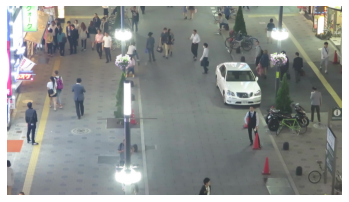

In [8]:
# Example: Original picture before detection

import matplotlib.pylab as plt
import cv2


temp_data = motdata3
list_motdata = os.listdir(temp_data)  
list_motdata.sort()

img_ex_path = temp_data + list_motdata[0]
img_ex_origin = cv2.imread(img_ex_path)
img_ex = cv2.cvtColor(img_ex_origin, cv2.COLOR_BGR2RGB)

plt.imshow(img_ex)
plt.axis('off')
plt.show()




---


**2. Object Detection with Faster R-CNN**

*  We will use a pretrained Faster R-CNN model using ResNet50 as a backbone with FPN.





---




In [9]:
# Import required packages/modules first

from PIL import Image
import numpy as np
import torch
import torchvision
from torchvision import transforms as T

In [10]:
# Download the pretrained Faster R-CNN model from torchvision

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()
torch.cuda.is_available()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

True

In [11]:
# Define the class names given by PyTorch's official Docs

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


In [12]:
# Defining a function for get a prediction result from the model

def get_prediction(img_path, threshold):
  img = Image.open(img_path) # Load the image
  transform = T.Compose([T.ToTensor()]) # Defing PyTorch Transform
  img = transform(img) # Apply the transform to the image
  pred = model([img]) # Pass the image to the model
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())] # Get the Prediction Score
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] # Get list of index with score greater than threshold.
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return pred_boxes, pred_class

In [13]:
# Defining a api function for object detection

def object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=1.5, text_th=3):
 
  boxes, pred_cls = get_prediction(img_path, threshold) # Get predictions
  img = cv2.imread(img_path) # Read image with cv2
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
  for i in range(len(boxes)):
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
    cv2.putText(img,pred_cls[i], boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class
  plt.figure(figsize=(15,20)) # display the output image
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

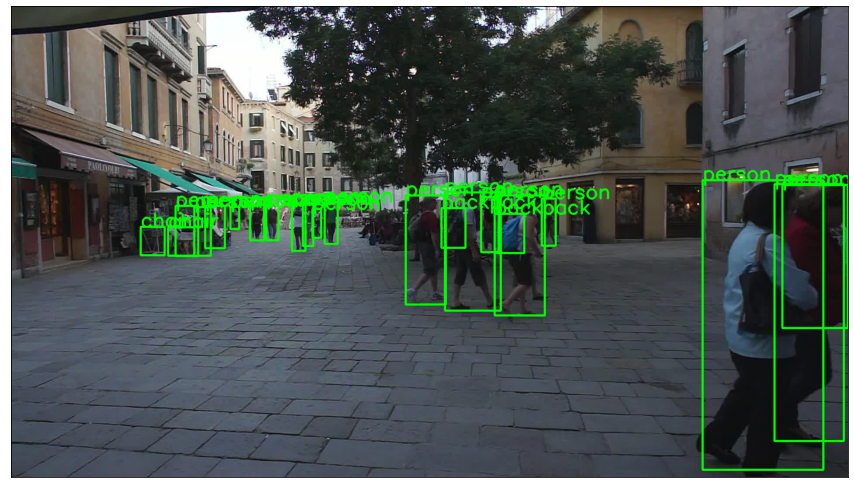

In [15]:
# Example: After detection
temp_data = motdata2
list_motdata = os.listdir(temp_data)

det_path = temp_data + list_motdata[1]
object_detection_api(det_path, threshold=0.7)

threshold 를 바꿔가면서 물체들이 어떻게 검출되는지 확인할 수 있습니다. 



---


**3. Object ID Tracking with SORT**


*   Simple Online and Realtime Tracking (SORT) algorithm for object ID tracking 

---



In [16]:
# Git clone: SORT Algorithm

!cd "{path}";git clone https://github.com/abewley/sort.git
  
sort = join(path,'sort/')
sys.path.append(sort)

Cloning into 'sort'...
remote: Enumerating objects: 202, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 202 (delta 0), reused 0 (delta 0), pack-reused 198
Receiving objects: 100% (202/202), 1.21 MiB | 7.91 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [17]:
# requirement for sort
!cd "{sort}";pip install -r requirements.txt

     |████████████████████████████████| 177 kB 5.4 MB/s 
     |████████████████████████████████| 12.5 MB 38.5 MB/s 
     |████████████████████████████████| 1.5 MB 45.9 MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110474 sha256=cbec61e730354fd4acda86cb09fdb7f1e20ea9e31671096a45156e4351318b6b
  Stored in directory: /root/.cache/pip/wheels/ce/e0/ee/a2b3c5caab3418c1ccd8c4de573d4cbe13315d7e8b0a55fbc2
  Created wheel for lap: filename=lap-0.4.0-cp37-cp37m-linux_x86_64.whl size=1590183 sha256=1d1e551aafdd2c68fd0b14290dada37f8d97b1c939f1f92be453876b05c947c1
  Stored in directory: /root/.cache/pip/wheels/b1/0b/e3/ef9daf1b5547b56389e42c80c3100f1e6479bf5fd00fd9d6ba
Successfully built filterpy lap
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3
ERROR: pip's dependency resolver does not currently take into account all the packages th

In [18]:
# Optional: if error occurs, you might need to re-install scikit-image and imgaug

#!pip uninstall scikit-image
#!pip uninstall imgaug
#!pip install imgaug
#!pip install -U scikit-image

import skimage
print(skimage.__version__)

0.17.2


In [19]:
# Detection information on all the images is well-refined as a json file, which is available at our course git repo

!cd "{path}";git clone https://github.com/hwanhuh/LG_AI_Lab.git

Cloning into 'LG_AI_Lab'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 108 (delta 48), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (108/108), 4.42 MiB | 11.34 MiB/s, done.
Resolving deltas: 100% (48/48), done.


In [56]:
import json
import collections
from pprint import pprint
from sort import *

jsonpath = join(path,'LG_AI_Lab/3_MOT_detinfo.json')

with open(jsonpath) as data_file:    
   data = json.load(data_file)
odata = collections.OrderedDict(sorted(data.items()))

In [57]:
img_path = motdata    # img root path

# Making new directory for saving results
save_path = join(path, 'save/')
!mkdir "{save_path}"

mkdir: cannot create directory ‘/content/MOT/save/’: File exists


In [58]:
mot_tracker = Sort()      # Tracker using SORT Algorithm

In [59]:
from tqdm import tqdm

for key in tqdm(odata.keys()):   
    arrlist = []
    det_img = cv2.imread(os.path.join(img_path, key))
    overlay = det_img.copy()
    det_result = data[key] 
    
    for info in det_result:
        bbox = info['bbox']
        labels = info['labels']
        scores = info['scores']
        templist = bbox+[scores]
        
        if labels == 1: # label 1 is a person in MS COCO Dataset
            arrlist.append(templist)
            
    track_bbs_ids = mot_tracker.update(np.array(arrlist))
    
    mot_imgid = key.replace('.jpg','')
    newname = save_path + mot_imgid + '_mot.jpg'
    
    for j in range(track_bbs_ids.shape[0]):  
        ele = track_bbs_ids[j, :]
        x = int(ele[0])
        y = int(ele[1])
        x2 = int(ele[2])
        y2 = int(ele[3])
        track_label = str(int(ele[4])) 
        cv2.rectangle(det_img, (x, y), (x2, y2), (0, 255, 255), 4)
        cv2.putText(det_img, '#'+track_label, (x+5, y-10), 0,0.6,(0,255,255),thickness=2)
        
    cv2.imwrite(newname, det_img)

100%|██████████| 525/525 [00:59<00:00,  8.83it/s]


In [60]:
import re

path = save_path
paths = [os.path.join(path , i ) for i in os.listdir(path) if re.search(".jpg$", i )]
store1 = []
store2 = []
for i in paths :
    if len(i) == 19 :
        store2.append(i)
    else :
        store1.append(i)

paths = list(np.sort(store1)) + list(np.sort(store2))

In [61]:
pathOut = os.getcwd() + '/out.mp4'
fps = 30

import cv2
frame_array = []
for idx , path in enumerate(paths) : 
    if (idx % 2 == 0) | (idx % 5 == 0) :
        continue
    img = cv2.imread(path)
    height, width, layers = img.shape
    size = (width,height)
    frame_array.append(img)

out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
for i in range(len(frame_array)):
    out.write(frame_array[i])
out.release()

In [62]:
from google.colab import files
files.download('out.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>